<a href="https://colab.research.google.com/github/HyunaShin/Chatbot_Project/blob/master/Plant_Seeding_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
api_token = {"username":"hyuna1615","key":"471ac110008706a0be1f1d4f780e4edd"}
! chmod 600 /root/.kaggle/kaggle.json
import json
import zipfile
import os

with open('/root/.kaggle/kaggle.json', 'w') as file:
   json.dump(api_token, file)
! kaggle competitions download -c plant-seedlings-classification

  0% 0.00/5.13k [00:00<?, ?B/s]
100% 5.13k/5.13k [00:00<00:00, 10.9MB/s]
 94% 81.0M/86.0M [00:01<00:00, 64.7MB/s]
100% 86.0M/86.0M [00:01<00:00, 65.9MB/s]
100% 1.59G/1.60G [00:34<00:00, 100MB/s] 
100% 1.60G/1.60G [00:34<00:00, 50.3MB/s]


In [6]:
! ls

deep_learning  dog_vs_cat_dataset  sample_data


In [10]:
! unzip test.zip && unzip train.zip
! unzip sample_submission.csv.zip

Archive:  test.zip
   creating: test/
  inflating: test/c0461776c.png      
  inflating: test/4bbfd1e05.png      
  inflating: test/1d0cbd819.png      
  inflating: test/93079d970.png      
  inflating: test/856f2910a.png      
  inflating: test/976e4e079.png      
  inflating: test/b31292706.png      
  inflating: test/29bab7cad.png      
  inflating: test/37297a64c.png      
  inflating: test/f2dc546ca.png      
  inflating: test/b6a3f7876.png      
  inflating: test/8874bba69.png      
  inflating: test/1459e96a0.png      
  inflating: test/9a3f20121.png      
  inflating: test/5315c2dca.png      
  inflating: test/b7a7f6390.png      
  inflating: test/20e562fd5.png      
  inflating: test/e3f50adfc.png      
  inflating: test/6ba4ef411.png      
  inflating: test/acdb75e00.png      
  inflating: test/e0ec5b6a1.png      
  inflating: test/219fd68d5.png      
  inflating: test/41f1c3cdb.png      
  inflating: test/8c98a6e9b.png      
  inflating: test/1bf9b94a6.png      
  inflating:

In [11]:
import os
os.listdir()

['.config',
 'train.zip',
 'test',
 'deep_learning',
 'sample_submission.csv.zip',
 'test.zip',
 'train',
 'dog_vs_cat_dataset',
 'sample_submission.csv',
 'sample_data']

In [12]:
! cd train && ls

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherds Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [13]:
! find train -type f | wc -l

4750


In [14]:
! find test -type f | wc -l

794


In [0]:
#importing all the necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
from glob import glob
import itertools


from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

scale = 70
seed = 7

In [15]:
#getting the data and resizing the images
path_to_images = "./train/*/*.png"
images = glob(path_to_images)

trainingset = []
traininglabels = []
num = len(images)
count = 1

for i in images:
  print(str(count)+'/'+str(num), end = "\r" )
  trainingset.append(cv2.resize(cv2.imread(i), (scale, scale)))
  traininglabels.append(i.split("/")[-2])
  count = count +1
 
trainingset = np.asarray(trainingset)
traininglabels = pd.DataFrame(traininglabels)

In [16]:
# trainingset.shape, trainingset[0]
trainingset.shape, traininglabels.shape

((4750, 70, 70, 3), (4750, 1))

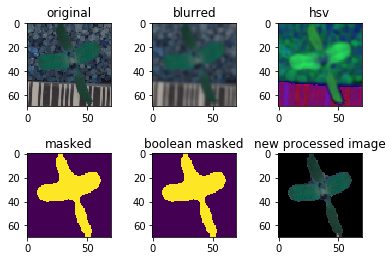

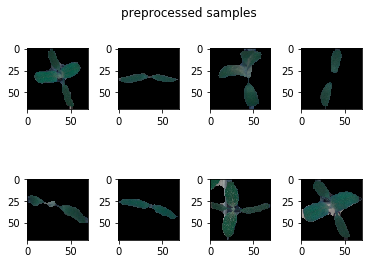

In [24]:
#preprocessing images and remove the background


new_train = []
sets = []; getEx = True

for i in trainingset:
  blurr = cv2.GaussianBlur(i,(5,5),0) #aussianBlur --> 엣지 검출, 영상처리 과정에서 큰 영향, Canny Detection으로 선만 따올수도 있음
  hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
  # GREEN PARAMETERS
  lower = (25,40,50)
  upper = (75,255,255)
  mask = cv2.inRange(hsv, lower, upper)
  struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
  mask =cv2.morphologyEx(mask, cv2.cv2.MORPH_CLOSE, struc)
  boolean = mask > 0
  new = np.zeros_like(i, np.uint8)
  new[boolean] = i[boolean]
  new_train.append(new)
  
  if getEx:
    plt.subplot(2,3,1);plt.imshow(i), plt.title("original")
    plt.subplot(2,3,2);plt.imshow(blurr), plt.title("blurred")
    plt.subplot(2,3,3);plt.imshow(hsv), plt.title('hsv')
    plt.subplot(2,3,4);plt.imshow(mask), plt.title("masked")
    plt.subplot(2,3,5);plt.imshow(boolean), plt.title('boolean masked')
    plt.subplot(2,3,6);plt.imshow(new) , plt.title('new processed image')
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    plt.show()
    getEx = False
    
new_train = np.asarray(new_train)


for i in range(8):
  plt.suptitle("preprocessed samples")
  plt.subplot(2,4, i+1)
  plt.imshow(new_train[i])
  plt.subplots_adjust(hspace = 0.5, wspace = 0.5)

Classes['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
12


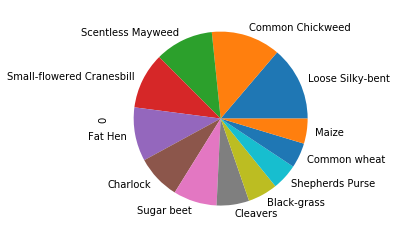

In [27]:
# converting the labels into numbers

labels = preprocessing.LabelEncoder()
labels.fit(traininglabels[0])
print("Classes" + str(labels.classes_))

encodedlabels = labels.transform(traininglabels[0])
clearalllabels = np_utils.to_categorical(encodedlabels)
classes = clearalllabels.shape[1]
print(str(classes))

traininglabels[0].value_counts().plot(kind = 'pie')

In [0]:
# defining our model and splitting the dataset

new_train = new_train/255
x_train, x_test, y_train, y_test = train_test_split(new_train, clearalllabels, test_size = 0.1, random_state = seed, stratify = clearalllabels)

In [0]:
# prevent overfitting

generator = ImageDataGenerator(rotation_range = 180,zoom_range = 0.1, width_shift_range = 0.1, height_shift_range = 0.1 , horizontal_flip = True,
                              vertical_flip = True )

generator.fit(x_train)

In [44]:
# Defining the Convolutional Neural Network
# 4 Convolution Layers, 3 Fully Connected layers


np.random.seed(seed)
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), input_shape = (scale, scale, 3), activation = "relu")) # 필터 + activation func.세팅
model.add(BatchNormalization(axis = 3)) # 이파리색깔을 batch단위로 정규분포화 시킴
model.add(Conv2D(filters = 64, kernel_size = (5,5), activation = "relu"))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization(axis = 3))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 128, kernel_size=(5,5), activation="relu"))
model.add(BatchNormalization(axis = 3))
model.add(Conv2D(filters = 128, kernel_size= (5,5) , activation = "relu"))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization(axis = 3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5,5) , activation = "relu"))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5,5) , activation = "relu"))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization(axis = 3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes, activation = "softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization_14 (Batc (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_8 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 27, 27, 128)       204928    
__________

In [46]:
! ls

deep_learning	    sample_submission.csv      test.zip
dog_vs_cat_dataset  sample_submission.csv.zip  train
sample_data	    test		       train.zip


In [64]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 28.0MB/s 


In [0]:
# fitting the cnn onto the data
lrr = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.4, min_lr = 0.00001)

filepath="./weights.last_auto4.hdf5"
checkpoints = ModelCheckpoint(filepath, monitor='val_acc', 
                              verbose=1, save_best_only=True, mode='max')


callbacks_list = [checkpoints, lrr]
# checkpoints_full = ModelCheckpoint(filepath, monitor='val_acc', 
#                                  verbose=1, save_best_only=False, mode='max')

In [0]:
model.fit_generator(generator.flow(x_train, y_train, batch_size = 75), epochs = 35, validation_data = (x_test, y_test), steps_per_epoch = x_train.shape[0], callbacks = callbacks_list)

Epoch 1/35
4275/4275 [==============================] - 466s 109ms/step - loss: 0.1816 - acc: 0.9312 - val_loss: 1.5559 - val_acc: 0.6632

Epoch 00001: val_acc improved from -inf to 0.66316, saving model to ./weights.last_auto4.hdf5
Epoch 2/35
4275/4275 [==============================] - 464s 109ms/step - loss: 0.1290 - acc: 0.9499 - val_loss: 0.3322 - val_acc: 0.9179

Epoch 00002: val_acc improved from 0.66316 to 0.91789, saving model to ./weights.last_auto4.hdf5
Epoch 3/35
4275/4275 [==============================] - 468s 109ms/step - loss: 0.0996 - acc: 0.9611 - val_loss: 0.2757 - val_acc: 0.9389

Epoch 00003: val_acc improved from 0.91789 to 0.93895, saving model to ./weights.last_auto4.hdf5
Epoch 4/35
4275/4275 [==============================] - 465s 109ms/step - loss: 0.0793 - acc: 0.9694 - val_loss: 0.8905 - val_acc: 0.8042

Epoch 00004: val_acc did not improve from 0.93895
Epoch 5/35
4275/4275 [==============================] - 467s 109ms/step - loss: 0.0652 - acc: 0.9754 - val

In [54]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file text file.
# 특정 폴더 안으로 파일 삽입
uploaded = drive.CreateFile({'title': 'mnist_mlp_model.h5', "parents": [{"kind": "drive#fileLink","id": 'your_drive_id'}]})
uploaded.SetContentString('Sample upload file content')
uploaded.SetContentFile('mnist_mlp_model.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

# 3. Load a file by ID and print its contents.
downloaded = drive.CreateFile({'id': uploaded.get('id')})


4275/4275 [==============================] - 5s 1ms/step
[2.4844620700189246, 0.07415204678362573]
475/475 [==============================] - 0s 824us/step
[2.4844661235809324, 0.07368421055768666]
